<a href="https://colab.research.google.com/github/Gabriel-git24/Cacao_disease_classification/blob/main/Capstone_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.utils import class_weight
import numpy as np
import pathlib

data_dir = "/content/drive/MyDrive/Capstone Project/archive (5)/split_dataset"
image_size = (224, 224)
batch_size = 32
num_epochs = 50

class_names = [
    "Cassava___bacterial_blight",
    "Cassava___brown_streak_disease",
    "Cassava___green_mottle",
    "Cassava___mosaic_disease",
    "Cassava___healthy"
]

num_classes = len(class_names)

# datagen = ImageDataGenerator(
#     rescale=1./255
# )

# train_generator = datagen.flow_from_directory(
#     f"{data_dir}/train",
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode="categorical",
#     shuffle=True
# )

# val_generator = datagen.flow_from_directory(
#     f"{data_dir}/val",
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode="categorical",
#     shuffle=False # WHY IS THIS FALSE HERE?
# )

# test_generator = datagen.flow_from_directory(
#     f"{data_dir}/test",
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode="categorical",
#     shuffle=False # WHY IS THIS FALSE HERE?
# )

mixed_precision.set_global_policy('mixed_float16')

train_generator = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=True
)

val_generator = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/val",
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/test",
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_generator = train_generator.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
val_generator = val_generator.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
test_generator = test_generator.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

Found 14975 files belonging to 5 classes.
Found 3207 files belonging to 5 classes.
Found 3215 files belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50

def build_resnet_classifier_v1(input_shape=(224, 224, 3), num_classes=5, learning_rate=1e-5):

  base_model = ResNet50(
      weights = "imagenet",
      include_top = False,
      input_shape = input_shape
  )

  #freezing the base layers initially
  base_model.trainable = False

  #defining architecture
  model = models.Sequential([
      #define the input shape
      layers.Input(shape=input_shape),

      # #rescaling
      # layers.Rescaling(1./255),

      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(256, activation="relu"),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation="softmax", dtype="float32")
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss="categorical_crossentropy",
      metrics=['accuracy']
  )

  return model


In [ ]:
model = build_resnet_classifier_v1(input_shape=(224, 224, 3), num_classes=5)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
data_dir_train = f"{data_dir}/train"

# Get class names in alphabetical order (same as Keras)
class_names_sorted = sorted([d.name for d in pathlib.Path(data_dir_train).iterdir() if d.is_dir()])

# Count files per class
y_train = []
for idx, class_name in enumerate(class_names_sorted):
    class_path = pathlib.Path(data_dir_train) / class_name
    num_images = len(list(class_path.glob("*")))
    y_train.extend([idx] * num_images)

y_train = np.array(y_train)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(weights))
print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: np.float64(3.9407894736842106), 1: np.float64(1.9549608355091384), 2: np.float64(1.7934131736526946), 3: np.float64(1.661120354963949), 4: np.float64(0.3251900108577633)}


In [ ]:
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/Capstone Project/models/resnet_v1.keras",
    save_best_only=True,
    monitor="val_accuracy",
)

early_stopping = EarlyStopping(
   monitor='val_loss',
   patience=5,
   restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5
)

# Start training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=num_epochs,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 918s 2s/step - accuracy: 0.2984 - loss: 2.1294 - val_accuracy: 0.4328 - val_loss: 1.3372 - learning_rate: 1.0000e-05
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3816 - loss: 1.6231 - val_accuracy: 0.5270 - val_loss: 1.1952 - learning_rate: 1.0000e-05
Epoch 3/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4454 - loss: 1.4538 - val_accuracy: 0.5507 - val_loss: 1.1582 - learning_rate: 1.0000e-05
Epoch 4/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4933 - loss: 1.3481 - val_accuracy: 0.5759 - val_loss: 1.1067 - learning_rate: 1.0000e-05
Epoch 5/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5144 - loss: 1.3129 - val_accuracy: 0.5840 - val_loss: 1.0865 - learning_rate: 1.0000e-05
Epoch 6/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5438 - loss: 1.2663 - val_accuracy: 0.5912 - val_loss: 1.0709 - learning_rate: 1.0000e-05
Epoch 7/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - acc

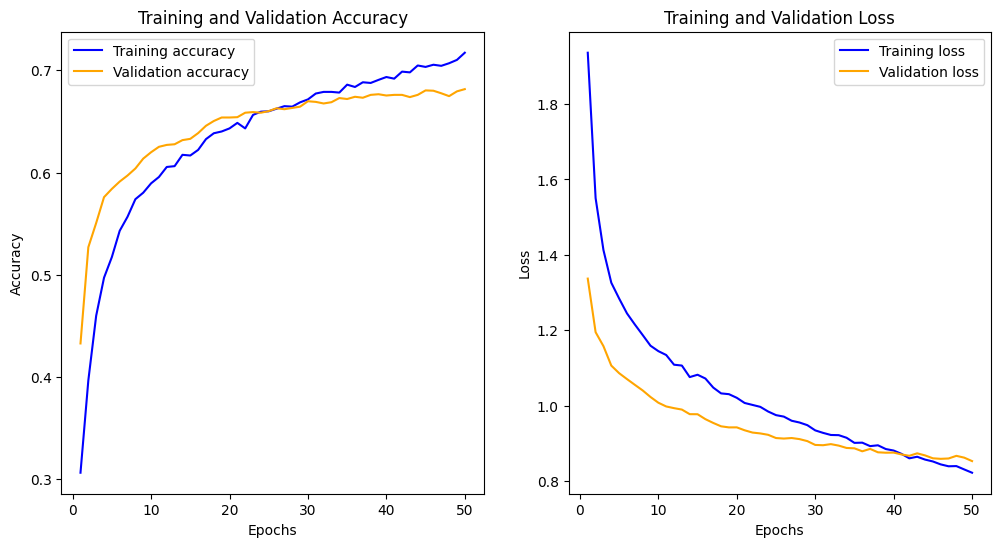

In [ ]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step


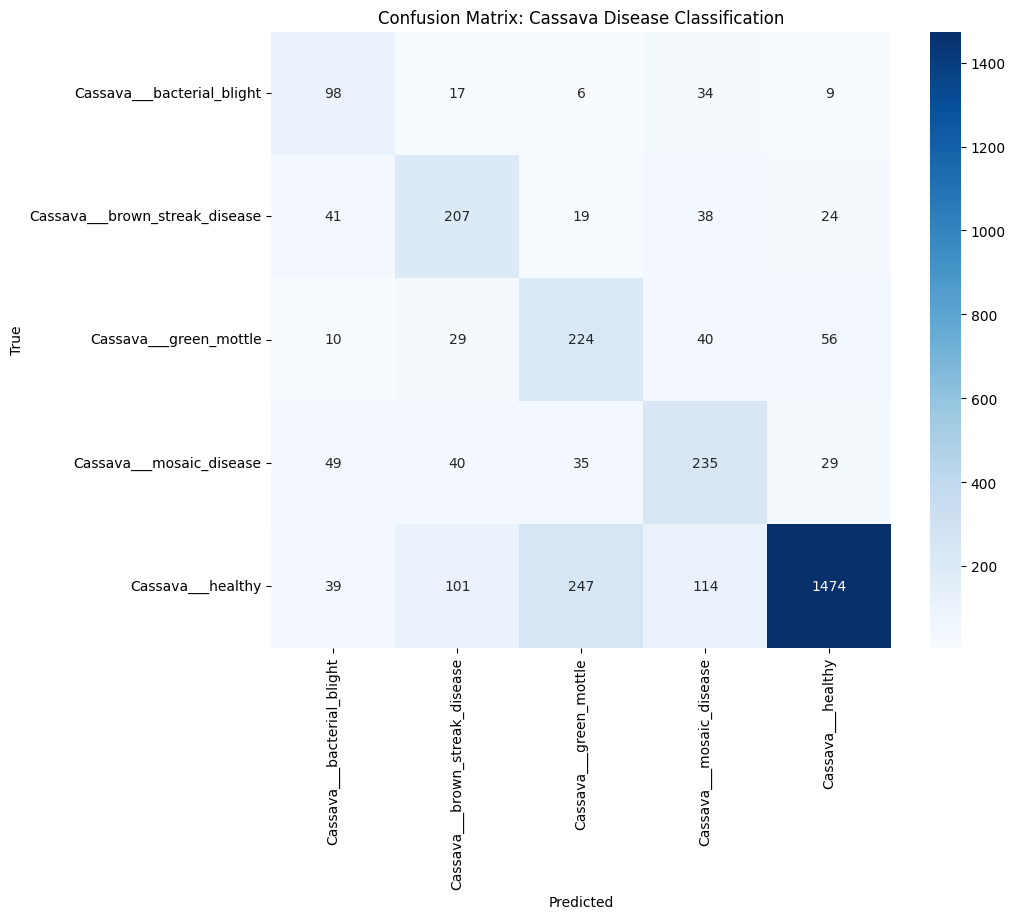

                                precision    recall  f1-score   support

    Cassava___bacterial_blight       0.41      0.60      0.49       164
Cassava___brown_streak_disease       0.53      0.63      0.57       329
        Cassava___green_mottle       0.42      0.62      0.50       359
      Cassava___mosaic_disease       0.51      0.61      0.55       388
             Cassava___healthy       0.93      0.75      0.83      1975

                      accuracy                           0.70      3215
                     macro avg       0.56      0.64      0.59      3215
                  weighted avg       0.75      0.70      0.71      3215



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Extract true labels
y_true = np.concatenate([y for x, y in test_generator], axis=0)

# FIX: Correct check for one-hot encoding (check number of dimensions)
if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)

# 2. Predict
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# 2. Identify which classes are actually present in your test data
# (This finds which of the 0-4 indices actually exist in y_true)
present_indices = np.unique(y_true).astype(int)
actual_labels = [class_names[i] for i in present_indices]

# 3. Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=actual_labels,
            yticklabels=actual_labels)



plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Cassava Disease Classification')
plt.show()

# 5. Classification Report
# We use actual_labels to ensure the count matches the 4 classes found
print(classification_report(y_true, y_pred, target_names=actual_labels))

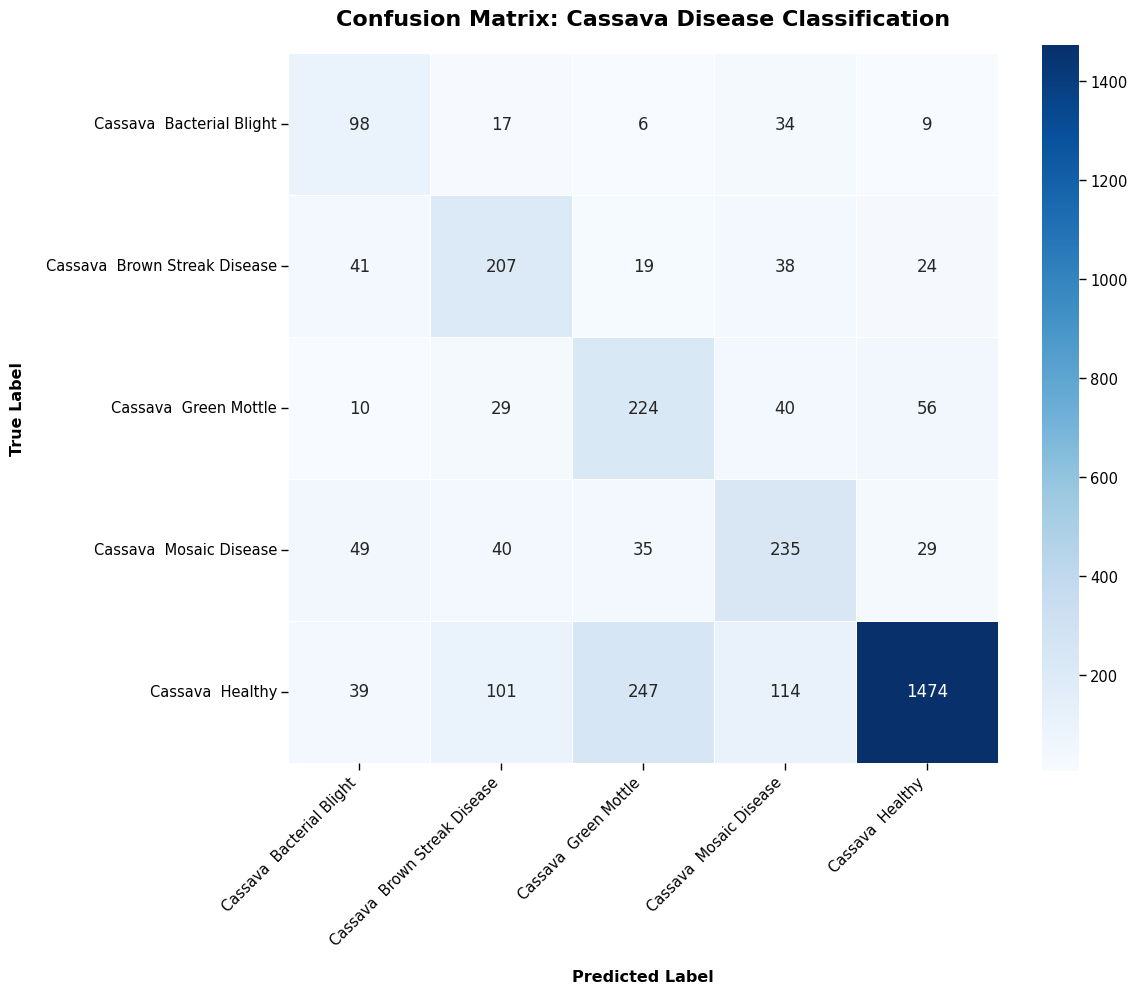

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Prepare cleaner labels (remove underscores and capitalize)
clean_labels = [label.replace('__', ' ').replace('_', ' ').title() for label in actual_labels]

# 2. Calculate normalized matrix for percentages
cm = confusion_matrix(y_true, y_pred)
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Create the plot
plt.figure(figsize=(12, 10))
sns.set_context("paper", font_scale=1.2) # Professional font scaling

# Use a mask or distinct colors to make the diagonal (correct hits) stand out
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=clean_labels,
            yticklabels=clean_labels,
            square=True,
            linewidths=.5,
            annot_kws={"size": 12})

# Add formatting details
plt.xlabel('Predicted Label', fontweight='bold', labelpad=15)
plt.ylabel('True Label', fontweight='bold', labelpad=15)
plt.title('Confusion Matrix: Cassava Disease Classification', fontsize=16, pad=20, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Regenerate the classification report, but this time as a dictionary
report = classification_report(y_true, y_pred, target_names=actual_labels, output_dict=True)

# Extract and print the requested metrics
print("Overall Accuracy:", report['accuracy'])
print("\nWeighted Average Precision:", report['weighted avg']['precision'])
print("Weighted Average Sensitivity (Recall):", report['weighted avg']['recall'])

Overall Accuracy: 0.6961119751166407

Weighted Average Precision: 0.7522570415876406
Weighted Average Sensitivity (Recall): 0.6961119751166407


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Assuming y_true, y_pred, and actual_labels are already defined from previous cells
# If not, you might need to re-run the prediction and label extraction steps.

# Generate the classification report as a dictionary
report_dict = classification_report(y_true, y_pred, target_names=actual_labels, output_dict=True)

# Convert the dictionary to a pandas DataFrame for a nice table format
df_report = pd.DataFrame(report_dict).transpose()

# Print the table, excluding the 'support' row for weighted avg and macro avg if desired for clarity
# Also, format numerical columns for better readability
print("\nClassification Report Table:")
print(df_report.round(4))



Classification Report Table:
                                precision  recall  f1-score    support
Cassava___bacterial_blight         0.4135  0.5976    0.4888   164.0000
Cassava___brown_streak_disease     0.5254  0.6292    0.5726   329.0000
Cassava___green_mottle             0.4218  0.6240    0.5034   359.0000
Cassava___mosaic_disease           0.5098  0.6057    0.5536   388.0000
Cassava___healthy                  0.9259  0.7463    0.8265  1975.0000
accuracy                           0.6961  0.6961    0.6961     0.6961
macro avg                          0.5593  0.6405    0.5890  3215.0000
weighted avg                       0.7523  0.6961    0.7143  3215.0000


In [ ]:
df_report

,precision,recall,f1-score,support
Cassava___bacterial_blight,0.413502,0.597561,0.488778,164.000000
Cassava___brown_streak_disease,0.525381,0.629179,0.572614,329.000000
Cassava___green_mottle,0.421846,0.623955,0.503371,359.000000
Cassava___mosaic_disease,0.509761,0.605670,0.553592,388.000000
Cassava___healthy,0.925879,0.746329,0.826465,1975.000000
accuracy,0.696112,0.696112,0.696112,0.696112
macro avg,0.559274,0.640539,0.588964,3215.000000
weighted avg,0.752257,0.696112,0.714252,3215.000000


In [ ]:
df_report.to_csv("df_report")


In [ ]:
df_report.to_csv("df_report.csv")

In [ ]:
from google.colab import files

files.download("df_report.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>